In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
import numpy as np
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import os

test = pd.read_csv(os.path.join('data', 'test_users.csv'), header=0, parse_dates=[1,2,3])
train = pd.read_csv(os.path.join('data', 'train_users_2.csv'), header=0, parse_dates=[1,2,3])

In [2]:
outcome = train.country_destination
labels = outcome.values
le = LabelEncoder()
y = le.fit_transform(labels)
train = train.drop(['country_destination'], axis=1)

id_test = test['id']

data = pd.concat((train, test), axis=0, ignore_index=True)
data = data.drop(['id','date_first_booking'], axis=1)

#date_account_created
data['dac_year'] = data.date_account_created.apply(lambda x: x.year)
data['dac_month'] = data.date_account_created.apply(lambda x: x.month)
data['dac_weekday'] = data.date_account_created.apply(lambda x: x.weekday())
data = data.drop(['date_account_created'], axis=1)

#timestamp_first_active
data['tfa_year'] = data.timestamp_first_active.apply(lambda x: x.year)
data['tfa_month'] = data.timestamp_first_active.apply(lambda x: x.month)
data['tfa_weekday'] = data.timestamp_first_active.apply(lambda x: x.weekday())
data = data.drop(['timestamp_first_active'], axis=1)

In [3]:
data.age = data.age.fillna(data.age.median())

In [4]:
bins = list(np.arange(15, 85, 5))
bins.insert(0,0)
bins.append(int(max(data.age)))

In [5]:
group_names = ['<15', '15-20', '20-25', '25-30', '30-35', '35-40', '40-45', '45-50', '50-55', '55-60', '60-65', '65-70', '70-75', '75-80', '>80']

In [6]:
data['age_bucket'] = pd.cut(data['age'], bins, labels=group_names)

In [7]:
data.gender = data.gender.replace('-unknown-','unknown')

In [8]:
data.ix[:, data.columns != 'age_bucket'] = data.ix[:, data.columns != 'age_bucket'].fillna('unknown')

In [9]:
to_be_dummified = ['gender', 'signup_method', 'signup_flow', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser','age_bucket']
for f in to_be_dummified:
    dummies = pd.get_dummies(data[f], prefix=f)
    data = data.drop([f], axis=1)
    data = pd.concat((data, dummies), axis=1)

In [10]:
clf = RandomForestClassifier(n_estimators=100, oob_score=True)
clf = clf.fit(data[:train.shape[0]], y)

In [12]:
y_pred = clf.predict_proba(data[train.shape[0]:])  

In [13]:
ids = []  #list of ids
cts = []  #list of countries
for i in range(len(id_test)):
    idx = id_test[i]
    ids += [idx] * 5
    cts += le.inverse_transform(np.argsort(y_pred[i])[::-1])[:5].tolist()

#Generate submission
sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
sub.to_csv(os.path.join('data', 'sub.csv'),index=False)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


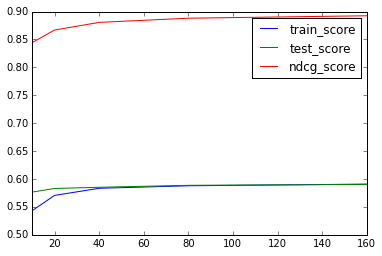